# Fitting Rotation Maps

## Methdolody

A common task for analyses of protoplanetary disks is to infer their geometrical properties, namely the source centre, $(x_0,\, y_0)$, the inclination $i$, position angle ${\rm PA}$ and stellar (dynamical) mass, $M_{\rm star}$, by fitting a simple Keplerian rotation pattern to a measured rotation pattern. In this notebook we'll look at how to use `eddy` to fit rotation maps.

We'll look at two different datasets: $^{12}{\rm CO}$ observations of TW Hya and HD 163296. The TW Hya data is described in [Huang et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...852..122H), and is available [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC), while the HD 163296 is from the DSHARP project with the data described in [Isella et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..49I/abstract) and available [here](https://bulk.cv.nrao.edu/almadata/lp/DSHARP/). There are many different ways of collapsing a cube to a velocity map and with various different programs. For now, we'll use the method presented in [Teague & Foreman-Mackey (2018)](https://ui.adsabs.harvard.edu/#abs/2018RNAAS...2c.173T) which has been packaged up as [`bettermoments`](https://github.com/richteague/bettermoments). These can be downloaded from the [`eddy` Dataverse](https://dataverse.harvard.edu/dataverse/eddy), or you can make them yourself.

## TW Hya - An (Almost) Geometrically Thin Case

To understand the basics we'll start with TW Hya. With an inclination close to face-on we can assume that the disk is geometrically thin.

### Loading up the Rotation Map

Within `fit_cube.py` we have defined a `rotationmap` class which provides all the functionality we'll need. Let's load it up.

In [1]:
%matplotlib inline
from eddy.fit_cube import rotationmap

When loading the data we need _at least_ the rotation map. If you have a map of the uncertainties for each pixel, they can be included with the `uncertainty` argument. If you don't, that's OK as it was assume a 10% uncertainty on each pixel by default. If you've used `bettermoments` to calculate your rotation map it will also spit out uncertainties for you, even if you use a traditional intensity weighted average velocity, using the equations from [Teague (2019)](https://iopscience.iop.org/article/10.3847/2515-5172/ab2125/meta). The uncertainty can be changed on the fly through the `cube.error` parameter.

We have also downsampled the data so that we only included (roughly) spatially independent pixel. Additionally you can enter any integer to downsample by that factor. This is optional but useful for speeding up things when you're playing around.

Using the `clip` argument we have also clipped the cube down to the region of interest. Note that when `eddy` is making a rotation map, it makes it _for the full image_, even if you're only fitting an inner region. Clipping down to the region of interest will considerably speed up the process.

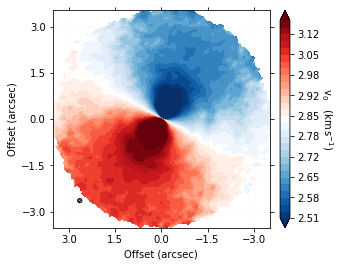

In [2]:
# Load up the data.

cube = rotationmap(path='../../cubes/TWHya_CO_cube_v0.fits',
                   uncertainty='../../cubes/TWHya_CO_cube_dv0.fits',
                   downsample=5, clip=3.5)

# Inspect the data.

cube.plot_data()

### Fitting the Rotation Map

Here we describe how to fit the data using the `fit_map` function.

First off we assume a geometrically thin, Keplerian disk model where

$$v_{\rm proj} = \sqrt{\frac{GM_{\rm star}}{r}} \cdot \cos \phi \cdot \sin i + v_{\rm LSR} \quad \text{or} \quad v_{\rm proj} = v_{\rm kep} \cdot \cos \phi \cdot \sin i + v_{\rm LSR} $$

where $\phi$ is the polar angle of the pixel (measured east of north relative to the redshifted major axis) and $v_{\rm LSR}$ is the systemic velocity. Thus we can fully describe the rotation pattern with five free parameters.

For the fitting, we need to know which of these values we're fixing and which we want to fit for. Given the extreme degeneracy between $i$ and $M_{\rm star}$, a good idea is to fix $i$ to a value found from fitting the continuum. So, for this example we want to find the source center, $(x0,\,  y0)$, the position angle of the disk, ${\rm PA}$, the stellar mass $M_{\rm star}$ and the systemic velocity, $v_{\rm LSR}$, while holding the inclination fixed at $i = 6.8^{\circ}$.

We the provide two things to `fit_map`: `p0`, a list of the initial guesses for the free parameters and `params`, which is a dictionary containing a) the indices of the free variables in `p0` as an **integer** and b) the fixed values for all other variables as a **float**. With the dictionaries it is possible to hold certain parameters fixed and others free. In particular, if you know the rotation direction of the disk then this is a good parameter to fix.

In [3]:
# Dictionary to contain the disk parameters.

params = {}

# Start with the positions of the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4

p0 = [0.0, 0.0, 151., 0.65, 2.8e3]

# Fix the other parameters.

params['inc'] = 6.8     # degrees
params['dist'] = 60.1   # parsec
params['beam'] = False  # should we convolve the model? **MUST BE A BOOLEAN**

# We must also specify the region to fit as we do not want to fit outside the map.
# This can be done with the `r_min` and `r_max` values. An inner radius is sometimes
# useful if the beam smearing in the inner region strongly affects the fit.

r_min = 2.0 * cube.bmaj
r_max = 3.25

The fitting has several steps:

1. Using the initial values in `p0` to deproject the data, it will create a mask of the regions to fit. This will be plotted as black contours over the original data.
2. If `optimize=True`, which is strongly recommended, it tries to find the values in `p0` which maximize the likelihood function. Using these updated `p0` values it will then recalculate the regions to fit.
3. It will sample the posterior distributions using `emcee`, returning either the 16th, 50th and 84th percentiles of the posterior distributions, or, if `return_samples=True`, will return all the samples of the posteriors.
4. It will the make diagnostic plots, included median model, corner covariance plots and traces.

Assuming:
	p0 = [${\rm x0}$, ${\rm y0}$, ${\rm PA}$, ${\rm mstar}$, ${\rm vlsr}$].
Optimized starting positions:
	p0 = ['2.14e-02', '2.33e-02', '1.51e+02', '6.04e-01', '2.84e+03']


100%|██████████| 1200/1200 [35:17<00:00,  1.76s/it] 


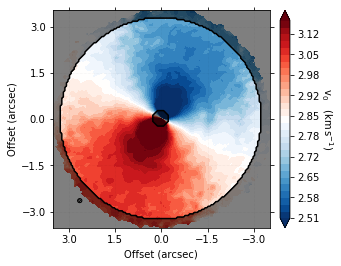

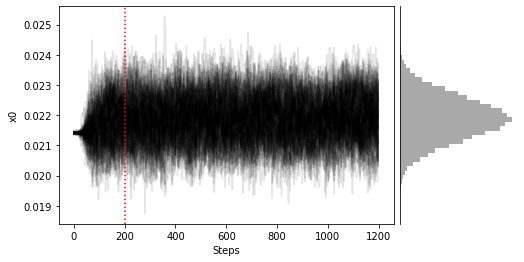

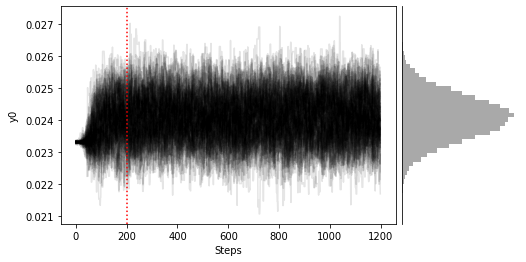

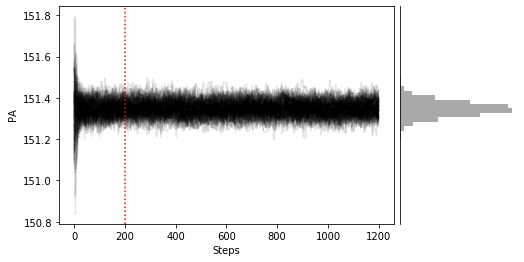

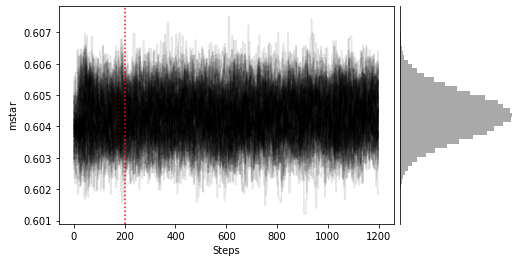

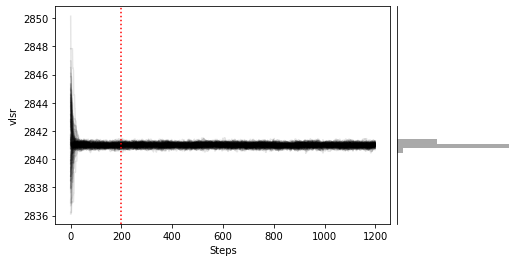

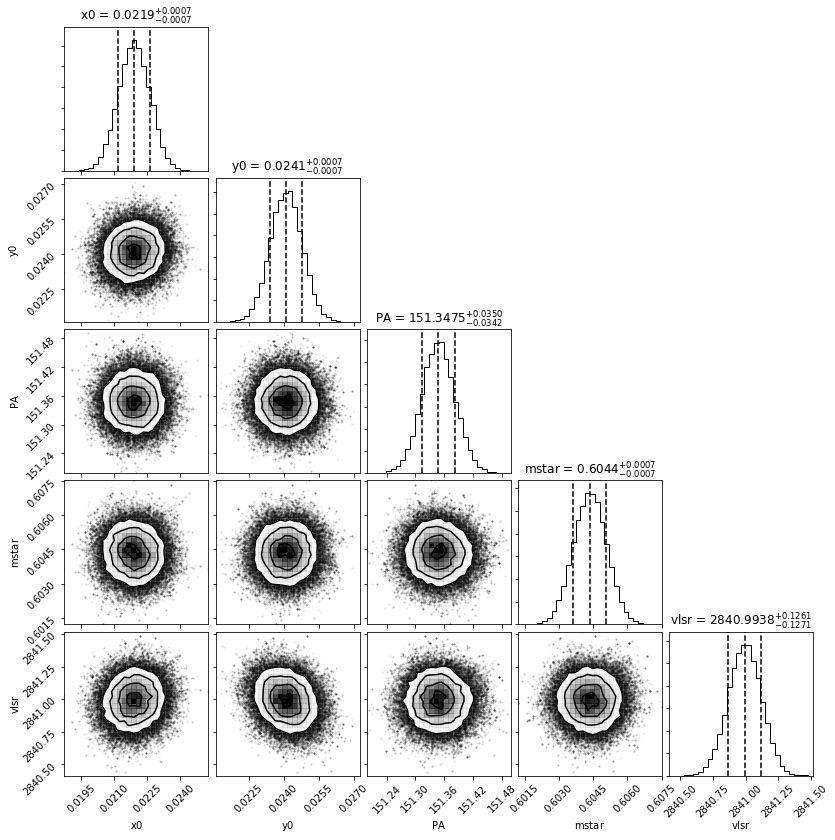

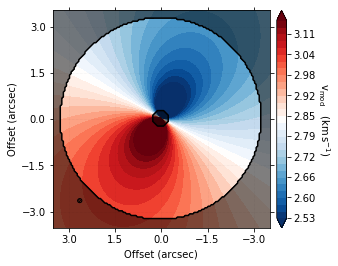

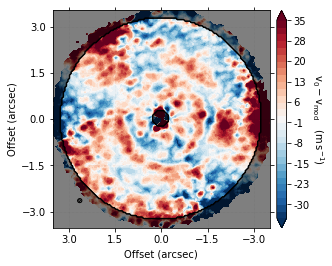

In [4]:
samples = cube.fit_map(p0=p0, params=params, r_min=r_min, r_max=r_max,
                       nwalkers=128, nburnin=200, nsteps=1000)

In the above plots, the shaded regions shows where the data is masked. This will be generated based on the starting positions of the walkers.

### Parallelization

It's sometimes useful to parallelize the fitting. We can implement a naive approach using the `multiprocessing` package. We can provide a `pool` variable to `fit_map` which will interface with the MCMC. Note that this is implemented using the `with` statement so that it deals with the starting and closing of the pool.

Assuming:
	p0 = [${\rm x0}$, ${\rm y0}$, ${\rm PA}$, ${\rm mstar}$, ${\rm vlsr}$].
Optimized starting positions:
	p0 = ['2.14e-02', '2.33e-02', '1.51e+02', '6.04e-01', '2.84e+03']


100%|██████████| 1200/1200 [09:02<00:00,  2.21it/s]


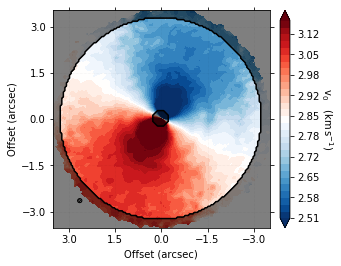

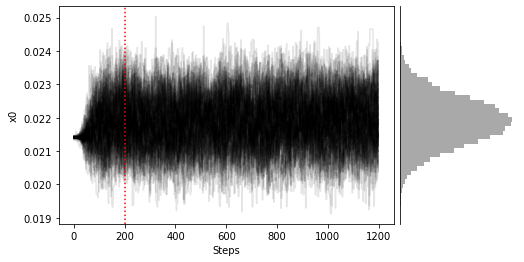

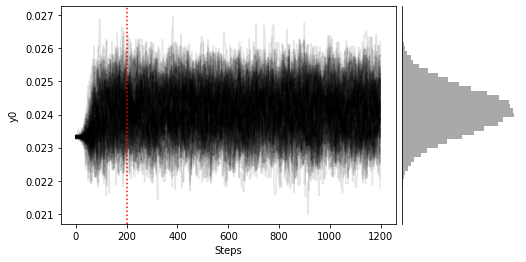

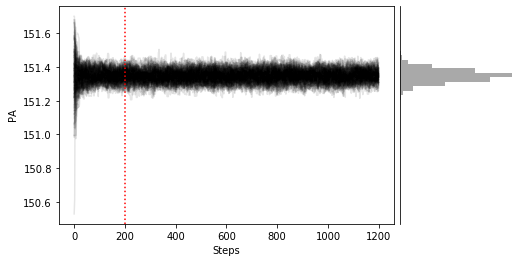

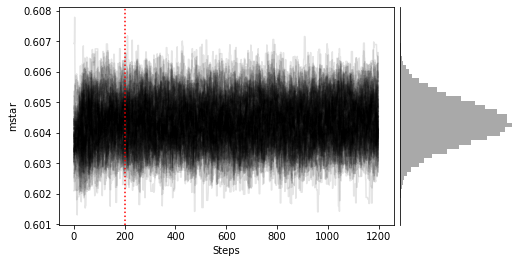

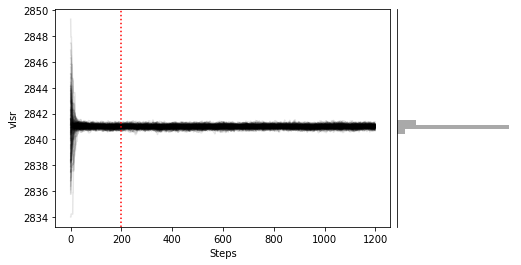

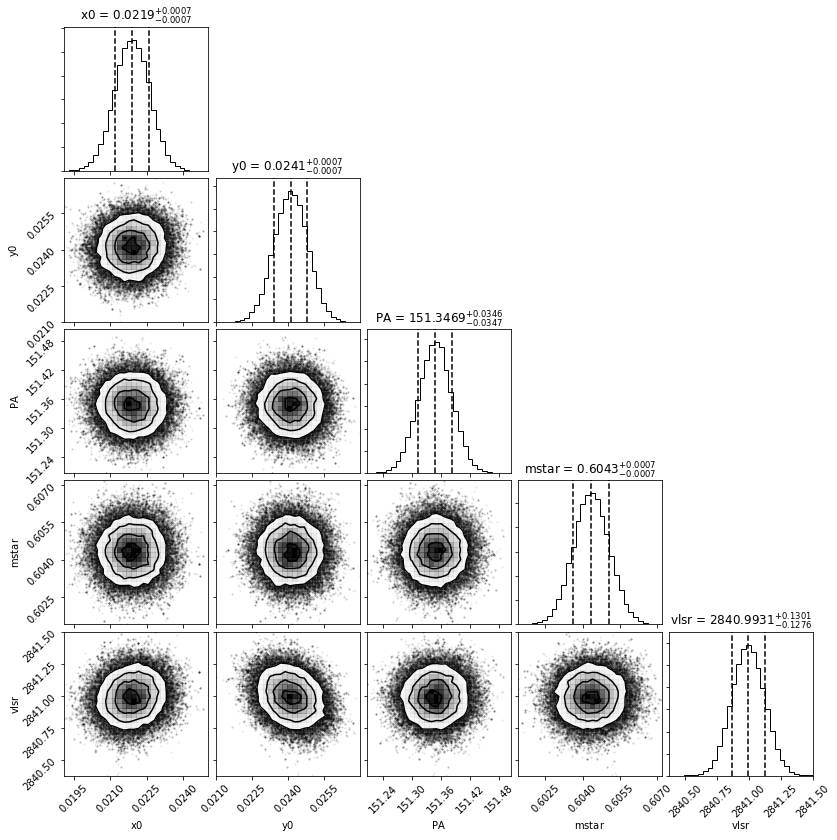

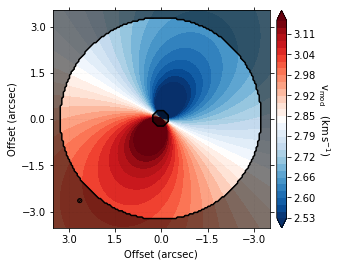

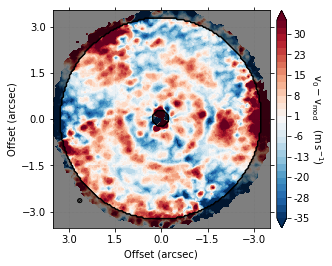

In [5]:
from multiprocessing import Pool

with Pool() as pool:
    cube.fit_map(p0=p0, params=params, r_min=r_min, r_max=r_max,
                 nwalkers=128, nburnin=200, nsteps=1000, pool=pool)

You'll not this is not vastly faster than the serial attempt because the whole class has to be pickled and read in and out, however we're able to run more walkers taking the same time. A more optimal parallel version is coming...